In [4]:
root_dir = 'Dataset1'

path: /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_2

train: /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_2/train

val: /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_2/val

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

# Explore Dataset

In [6]:
dataset_dir = os.path.join(root_dir)

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

Dataset1/images
Dataset1/images_resized
Dataset1/PCB_USED
Dataset1/output
Dataset1/Annotations
Dataset1/rotation
Dataset1/augmented_images
Dataset1/images/Mouse_bite
Dataset1/images/Spur
Dataset1/images/Short
Dataset1/images/Spurious_copper
Dataset1/images/Open_circuit
Dataset1/images/Missing_hole
Dataset1/output/3fold_crossval
Dataset1/output/images
Dataset1/output/labels
Dataset1/output/3fold_crossval/split_3
Dataset1/output/3fold_crossval/split_2
Dataset1/output/3fold_crossval/split_1
Dataset1/output/3fold_crossval/split_3/train
Dataset1/output/3fold_crossval/split_3/val
Dataset1/output/3fold_crossval/split_3/train/images
Dataset1/output/3fold_crossval/split_3/train/labels
Dataset1/output/3fold_crossval/split_3/val/images
Dataset1/output/3fold_crossval/split_3/val/labels
Dataset1/output/3fold_crossval/split_2/train
Dataset1/output/3fold_crossval/split_2/val
Dataset1/output/3fold_crossval/split_2/train/images
Dataset1/output/3fold_crossval/split_2/train/labels
Dataset1/output/3fold_c

In [7]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [8]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


# Create annotaton dataset

In [9]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [10]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [11]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_mouse_bite_08.jpg,3034,1586,mouse_bite,1018,1281,1058,1318
1,01_mouse_bite_08.jpg,3034,1586,mouse_bite,837,1099,874,1147
2,01_mouse_bite_20.jpg,3034,1586,mouse_bite,1339,1366,1382,1410
3,01_mouse_bite_20.jpg,3034,1586,mouse_bite,995,1312,1040,1351
4,01_mouse_bite_20.jpg,3034,1586,mouse_bite,792,1296,834,1340


# Visualization

In [12]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [13]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image


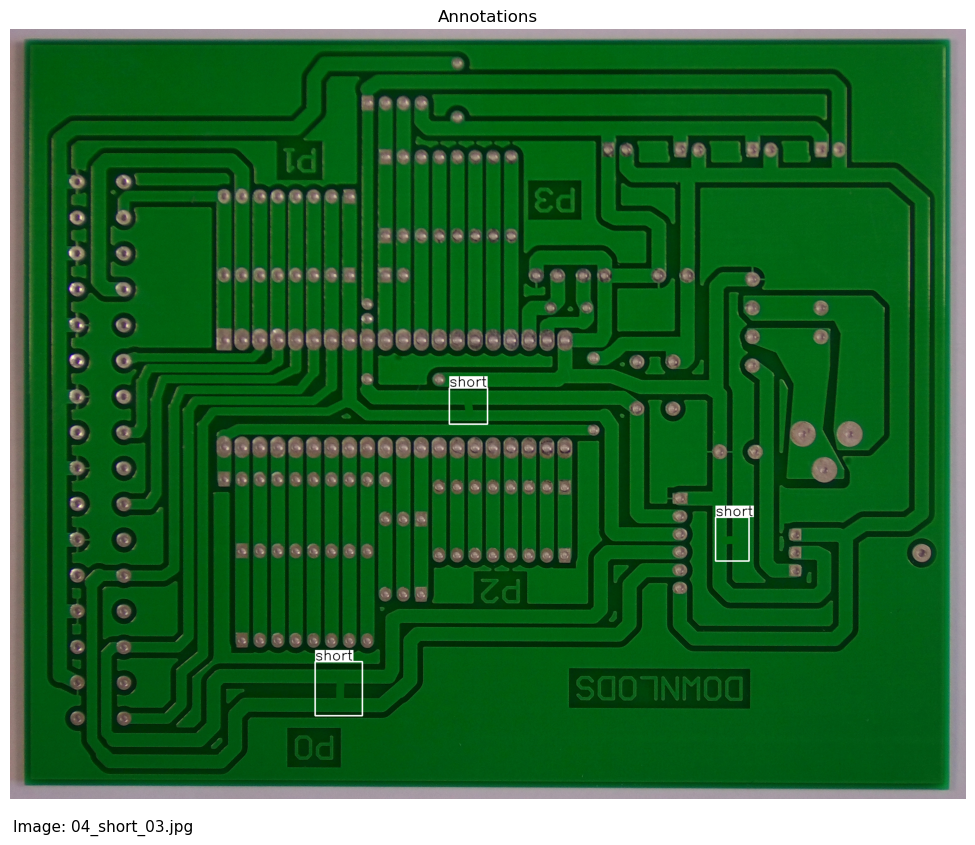

In [14]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

# Dataset preprocessing

In [12]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [13]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,01_mouse_bite_08.jpg,640,640,mouse_bite,214,516,223,531
1,01_mouse_bite_08.jpg,640,640,mouse_bite,176,443,184,462
2,01_mouse_bite_20.jpg,640,640,mouse_bite,282,551,291,568
3,01_mouse_bite_20.jpg,640,640,mouse_bite,209,529,219,545
4,01_mouse_bite_20.jpg,640,640,mouse_bite,167,522,175,540


# Split dataset

In [14]:
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [15]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)


In [16]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

# K-Fold Cross Validation

In [17]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [18]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [19]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [20]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

/var/folders/z_/xvvp4h796z9ggg4w6w81n__m0000gq/T/ipykernel_34555/2627102905.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`


,0,1,2,3,4,5
01_missing_hole_01,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_02,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_03,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_04,3.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_05,4.0,0.0,0.0,0.0,0.0,0.0


In [21]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [22]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

/var/folders/z_/xvvp4h796z9ggg4w6w81n__m0000gq/T/ipykernel_34555/3825890032.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
/var/folders/z_/xvvp4h796z9ggg4w6w81n__m0000g

In [23]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

,0,1,2,3,4,5
split_1,0.429448,0.548822,0.291176,0.659498,0.703571,0.366667
split_2,0.45625,0.602787,0.508591,0.469841,0.358974,0.808824
split_3,0.629371,0.369048,0.777328,0.394578,0.47678,0.397727


In [24]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [25]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [26]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

# Model Training

In [28]:
model = YOLO('yolov8s.pt')
results = {}

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 100
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data=dataset_yaml,
                epochs=epochs,
                batch=batch,
                lr0=0.001,
                lrf=0.0001,
                imgsz=imgsz,
                save_period=save_period,
                verbose=verbose,
                project=project,
                mixup=mixup)
    results[k] = model.metrics  # save output metrics for further analysis

Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=Dataset1/output/3fold_crossval/split_1/split_1_dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

train: Scanning /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_

train: New cache created: /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_1/train/labels.cache



val: Scanning /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_1/

val: New cache created: /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_1/val/labels.cache


Plotting labels to pcb/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to pcb/train6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      4.112      13.83      2.028         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.335    0.00833   0.000951   0.000431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      3.054      4.535      1.313         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.263      0.166     0.0852     0.0335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      2.702      3.219      1.213         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915     0.0431      0.236     0.0275    0.00967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      2.567      2.829      1.172         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.478      0.274       0.29      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      2.486      2.544      1.132         72        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.522      0.486      0.453      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      2.401      2.248      1.102         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.581      0.538      0.516      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      2.335      2.163      1.113         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.677      0.575       0.59       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      2.301      2.022      1.086         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.645      0.624      0.664      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      2.203      1.837      1.078         64        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.754      0.647      0.708      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      2.228      1.822      1.062         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.851      0.624      0.737      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      2.242      1.802      1.064         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.837      0.711      0.789       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      2.177      1.749      1.053         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.791      0.655      0.698       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      2.058      1.602      1.049         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.841      0.701      0.786       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G       2.09      1.564      1.047         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.879       0.76      0.824       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      2.105      1.583      1.025         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.884      0.723        0.8      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      2.116      1.591      1.033         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.93      0.743       0.83      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      2.052      1.499      1.017         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.914      0.792      0.847      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      2.031      1.501      1.024         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.906        0.8      0.862      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      2.048       1.51      1.027         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.928      0.782      0.851      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      2.014      1.482     0.9938         50        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.92      0.782      0.849      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      2.045      1.514      1.014         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.904      0.791      0.857      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      2.008      1.471      1.016         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.871      0.809       0.86      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.989      1.366      1.018         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.925      0.801      0.872      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.965       1.37     0.9965         49        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.933      0.814      0.872      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.937      1.357      1.001         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.907      0.809      0.861      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      2.037       1.47      1.009         57        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915        0.9      0.796      0.858      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.952      1.364      1.006         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.854      0.815      0.868      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G       1.94      1.334      1.009         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.904       0.85      0.894      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.929      1.319      1.001         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.922      0.834      0.881       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.916      1.303     0.9888         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.943      0.804      0.887      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.952      1.318     0.9999         50        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.944       0.79      0.874      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.923      1.307     0.9947         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.931      0.788      0.855      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.883      1.287     0.9735         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.896      0.817      0.874      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.893      1.266     0.9826         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.911      0.822      0.889      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.831      1.207     0.9789         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.916      0.837      0.888      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.846      1.229     0.9851         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.955      0.837      0.904      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.885      1.269     0.9774         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.936      0.822      0.888      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.852      1.236     0.9889         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.935      0.836       0.89      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G       1.83      1.224     0.9675         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.935      0.824      0.889      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.855       1.23     0.9693         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.906      0.833       0.89      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.836      1.213     0.9722         51        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.955      0.843      0.909      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.843      1.226     0.9616         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.923      0.832      0.894      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.832      1.197     0.9728         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.949       0.84      0.898      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.816      1.203      0.973         75        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.956      0.854      0.914      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.848      1.224     0.9633         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.918      0.867      0.906      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.825       1.22     0.9635         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.941      0.842      0.904      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.821      1.183     0.9546         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.954      0.842      0.907      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.795       1.14     0.9486         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.936       0.85        0.9      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.815      1.184     0.9735         49        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.914      0.861      0.902       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.751       1.12     0.9537         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.922      0.879      0.917       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      1.782      1.165     0.9523         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.928      0.856      0.911      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G       1.79      1.165     0.9567         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.932      0.856      0.901      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.726      1.104     0.9339         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.951      0.851      0.905      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.768      1.147     0.9472         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.94      0.855      0.907      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G       1.72      1.064     0.9466         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.963      0.821      0.903       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.733      1.116     0.9411         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.951      0.856      0.912      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.745      1.113     0.9485         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.93      0.859        0.9      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G       1.75       1.12     0.9364         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.942      0.848      0.905      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.747      1.078     0.9313         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.943      0.864      0.898      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G       1.75      1.107     0.9511         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.95      0.858      0.907      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.725      1.102     0.9444         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.94      0.868      0.906      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.745      1.106     0.9503         59        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.936       0.88      0.908      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.753      1.128     0.9397         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.917      0.878      0.913      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.681      1.046     0.9337         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.954       0.86      0.922       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.704      1.047     0.9375         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.951      0.876      0.914      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.721      1.084     0.9381         89        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.944      0.872      0.915      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G       1.67      1.014     0.9319         68        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.94      0.903      0.929      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.681      1.052     0.9406         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.96      0.879      0.925      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.653      1.017     0.9271         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.94      0.884      0.919      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.671      1.025     0.9361         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.953       0.87      0.926      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.646     0.9964     0.9299         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.953      0.862      0.928      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.648     0.9801      0.929         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.953      0.869      0.927      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.641      1.012     0.9196         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.937      0.874      0.921      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.658      1.052     0.9256         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.929       0.89      0.926      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.657      1.036     0.9279         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.959      0.876      0.926      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      1.636     0.9967     0.9198         74        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.944      0.878      0.922      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G       1.65      1.043     0.9329         68        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.945      0.877      0.924      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.616     0.9912     0.9206         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.962       0.88      0.933      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      1.595     0.9615     0.9124         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.939      0.867      0.915       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G       1.64      1.013      0.927         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.933      0.889      0.929      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.584     0.9297     0.9188         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.964      0.872      0.926      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.559     0.9222     0.9102         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.962       0.88      0.928      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.577      0.959     0.9135         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.956      0.891      0.926      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.555      0.953     0.9163         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.957      0.887      0.927      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.597     0.9774      0.921         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.955      0.887      0.922      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.576      0.941     0.9122         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.948      0.887      0.916      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      1.561     0.9397     0.9098         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.95      0.891      0.924      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      1.556     0.9403     0.9235         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.963      0.881      0.922      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.559     0.9362     0.9033         49        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.953      0.882      0.924      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.546     0.9242     0.9172         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.961      0.887      0.928      0.462


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      1.353     0.6803     0.8922         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.945      0.885       0.92      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.351     0.6509     0.8803         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.951      0.875      0.916      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.313     0.6218     0.8898         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.956      0.874      0.917      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      1.296     0.6154     0.8767         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.953      0.871      0.913      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      1.307     0.6331     0.8814         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.949      0.876      0.916      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G       1.27     0.6024     0.8806         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.946       0.88      0.916      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      1.304     0.6171      0.876         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.943      0.892      0.921      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G       1.27     0.6022     0.8787         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.941      0.891      0.917       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G       1.26     0.5988     0.8761         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915       0.94      0.886      0.915      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      1.248     0.5947     0.8733         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        220        915      0.944      0.887      0.919       0.45



100 epochs completed in 12.208 hours.
Optimizer stripped from pcb/train6/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train6/weights/best.pt, 22.5MB

Validating pcb/train6/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M1)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        220        915      0.964      0.872      0.926      0.466
          missing_hole         33        140      0.993      0.994       0.99      0.588
            mouse_bite         40        163      0.954      0.804        0.9      0.428
          open_circuit         26         99      0.968      0.838      0.907      0.401
                 short         44        184      0.961      0.929      0.944      0.461
                  spur         46        197      0.982      0.741      0.863      0.441
       spurious_copper         31        132      0.924      0.924      0.952      0.476
Speed: 1.2ms preprocess, 307.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to pcb/train6
Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=Dataset1/output/3fold_crossval/split_2/split_2_dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_peri

train: Scanning /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_

train: New cache created: /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_2/train/labels.cache



val: Scanning /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_2/

val: New cache created: /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_2/val/labels.cache


Plotting labels to pcb/train62/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to pcb/train62
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.742      1.068     0.9548         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.972      0.965      0.977      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G       1.72      1.082     0.9527         51        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.975      0.951       0.97      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.829      1.161     0.9618         63        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.984      0.918      0.973      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.876      1.247     0.9747         87        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.966      0.925      0.956      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.898       1.26      0.975         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.97      0.917      0.959      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.815      1.152     0.9622         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.954      0.935       0.96      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.835      1.164     0.9813         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.956      0.921      0.954      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.837      1.169     0.9761         69        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.947      0.896       0.95      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.815      1.173     0.9665         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.969      0.922      0.958      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.864      1.219     0.9736         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.978      0.903      0.955      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.862       1.22      0.968         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.966      0.915      0.951      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.821      1.181     0.9622         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.956      0.926      0.959      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.844      1.219     0.9705         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.964      0.911      0.952      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.797      1.177     0.9581         82        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.959      0.919      0.952      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.775      1.135      0.955         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.955      0.915      0.948      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.783      1.115     0.9672         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.938      0.908      0.944       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G       1.77      1.146     0.9388         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.96      0.918       0.95      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G       1.82       1.13     0.9553         57        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.959      0.918      0.953      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.786      1.118     0.9554         51        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.955      0.925      0.949      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.763      1.094      0.943         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.968       0.92       0.95      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.807      1.191     0.9694         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.957      0.923       0.96      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.713      1.084     0.9371         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.928      0.963      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.737      1.061     0.9451         51        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.957      0.904      0.947      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.746      1.109     0.9387         57        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.985      0.913      0.957      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.745      1.123     0.9488         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.972      0.899      0.953       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.766      1.112     0.9451         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.963      0.909      0.959      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.709       1.09     0.9378         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.965       0.93      0.959      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.696      1.041     0.9399         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.928      0.962      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G       1.73      1.069     0.9413         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.982      0.917      0.961      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.702      1.024     0.9448         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.972      0.919      0.959      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.683      1.037     0.9368         59        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.963      0.908      0.955      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.682      1.071      0.942         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.953      0.914      0.954      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.694      1.084     0.9358         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.959      0.935      0.955      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.725      1.051     0.9428         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.908      0.955      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G       1.72      1.083     0.9449         71        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.965      0.919      0.958      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.671      1.068     0.9387         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.96      0.931      0.964        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.698      1.047     0.9445         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.977      0.927      0.962      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.677      1.026     0.9367         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.978       0.91      0.956      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.671      1.034     0.9241         57        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.977        0.9      0.957      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.667      1.017     0.9431         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.97      0.918      0.962      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.671      1.032     0.9322         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.957       0.93      0.955      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.663      1.005     0.9248         63        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.917      0.956      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.648      1.007     0.9231         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.928      0.958      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.636      1.021     0.9259         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.963      0.936      0.963      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.656      1.014     0.9286         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.979       0.92      0.968      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.628     0.9833     0.9268         73        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.921      0.964      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.607     0.9871     0.9276         70        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.972       0.93      0.966      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.594     0.9385     0.9131         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.97      0.928      0.962      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.634     0.9819     0.9266         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.97      0.932       0.96      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.612     0.9617     0.9193         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.972      0.942      0.967      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      1.605     0.9759     0.9166         59        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.97      0.939      0.962       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.641      1.006     0.9262         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.939      0.927      0.959      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.583     0.9589     0.9182         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.962      0.943      0.968      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.548      0.926     0.8997         49        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.963      0.936       0.96        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.597     0.9327     0.9242         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.973      0.909       0.96      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.607     0.9651     0.9175         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.981       0.93      0.968      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.569     0.9252     0.9224         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.979       0.93       0.97      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.574     0.9389     0.9138         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.94      0.939      0.962      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.576     0.9364     0.9144         64        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.983      0.892       0.96      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.565      0.936     0.9243         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.914      0.937      0.958      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.526     0.9138      0.913         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.969      0.915      0.956      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.572     0.9373     0.9174         51        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.981      0.915      0.962      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.549     0.9236     0.9107         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.972      0.929      0.958      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.544     0.9113     0.9124         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.977       0.93      0.963      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.518     0.9077     0.9081         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.975      0.928      0.959      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G       1.56     0.9208     0.9065         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.935      0.939      0.957        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G       1.53     0.9127     0.8975         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.936      0.925      0.953       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.531     0.9272     0.9145         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.937      0.964      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.498     0.8925     0.9057         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.969      0.941      0.962      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.568     0.9227     0.9054         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.972      0.936       0.96      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.487     0.8653     0.9024         64        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.979      0.922      0.964      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.499     0.9034     0.8993         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.955      0.942      0.966      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G       1.51     0.8844     0.9115         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.974      0.922      0.963      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.501     0.8796     0.9028         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.977      0.915      0.966      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.486     0.8876     0.9049         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.972      0.929      0.966      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      1.465     0.8634     0.8905         70        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.982      0.918      0.964      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.482     0.9003     0.9015         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.98      0.898       0.96      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.466     0.8461     0.9069         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.978      0.927      0.964      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      1.453     0.8533      0.895         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.956      0.945      0.965      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.452     0.8676     0.8948         59        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.978      0.926      0.964      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.451     0.8499     0.8987         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.976       0.93      0.961      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.409     0.8203      0.887         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.979      0.937      0.964      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.413     0.8255     0.8867         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.984      0.922      0.963      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.425     0.8094     0.8865         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.964      0.938      0.968      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.455     0.8577     0.9013         84        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.964      0.939      0.966      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.412     0.8355     0.8853         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.984      0.918      0.965      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G       1.44     0.8625     0.8874         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.98      0.927      0.967      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      1.462     0.8652      0.902         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.956      0.945      0.967      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.426     0.8392     0.8936         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.974      0.941      0.967      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.383     0.8024     0.8886         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.968      0.942      0.965      0.499


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      1.193     0.5676     0.8629         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.981      0.918      0.966      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.176     0.5515     0.8636         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.978      0.923      0.965      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.171     0.5438     0.8677         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961       0.98      0.927      0.967      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      1.156     0.5495     0.8556         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.977      0.939      0.969      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      1.154     0.5494     0.8534         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.974      0.939      0.967      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G       1.15     0.5318      0.852         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.944      0.969      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      1.116     0.5373     0.8589         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.944      0.969      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G      1.125     0.5343     0.8555         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.979      0.939      0.969      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      1.121     0.5265     0.8581         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.969      0.944      0.968      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      1.118     0.5263     0.8505         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        961      0.971      0.944       0.97      0.501



100 epochs completed in 12.019 hours.
Optimizer stripped from pcb/train62/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train62/weights/best.pt, 22.5MB

Validating pcb/train62/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M1)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        219        961      0.972      0.965      0.977      0.565
          missing_hole         33        146       0.99          1      0.992      0.691
            mouse_bite         39        173      0.982      0.936       0.97      0.532
          open_circuit         35        148      0.986      0.981      0.989      0.497
                 short         32        148      0.993      0.999      0.994      0.598
                  spur         29        126      0.966      0.911      0.933      0.499
       spurious_copper         51        220      0.915      0.964      0.985      0.575
Speed: 1.1ms preprocess, 311.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to pcb/train62
Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=Dataset1/output/3fold_crossval/split_3/split_3_dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_per

train: Scanning /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_


train: New cache created: /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_3/train/labels.cache


val: Scanning /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_3/

val: New cache created: /Users/spartan/Desktop/298/Dataset1/output/3fold_crossval/split_3/val/labels.cache
Plotting labels to pcb/train622/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to pcb/train622
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.751      1.065     0.9487         42        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.977       0.95       0.98      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.752       1.08     0.9522         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.98      0.951      0.977      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.838      1.178     0.9577         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.943      0.936      0.968      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.852      1.236     0.9676         84        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.941      0.935      0.957      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.881      1.265     0.9668         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.952      0.916      0.946      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.825      1.176     0.9645         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.959       0.93      0.956      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.832      1.213     0.9798         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.968      0.902      0.957      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.826       1.16     0.9606         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.956      0.939      0.962      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.818      1.169     0.9686         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.97      0.894      0.958      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.858       1.22     0.9737         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.929      0.905       0.94      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.844       1.18     0.9739         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.957      0.914      0.953      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.776      1.149     0.9548         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.96      0.918      0.948      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.826      1.178     0.9588         42        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.936      0.925      0.954      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.818      1.165     0.9721         80        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.956      0.904      0.952      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.817      1.136     0.9555         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.956      0.928      0.958      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.827      1.155     0.9676         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.957      0.913      0.949      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.794      1.134     0.9597         63        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.924      0.937      0.954      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.768      1.127     0.9605         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.939      0.919      0.955      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.759      1.112     0.9491         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.954      0.909      0.949      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G       1.74      1.116     0.9416         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.961      0.908      0.956      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.773      1.139     0.9522         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.967      0.925       0.96      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.751      1.103     0.9568         64        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.967      0.912      0.952      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G       1.77      1.109     0.9619         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.952       0.94      0.963      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.753      1.119      0.953         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.959      0.926      0.958      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.746      1.112     0.9491         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.964      0.943      0.963      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.752      1.125     0.9463         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.957       0.92      0.961       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.747       1.11     0.9498         50        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.968      0.927      0.965      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.697      1.033     0.9364         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.939      0.936      0.957      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.743      1.101     0.9537         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.97      0.907      0.955      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.675      1.052     0.9303         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.962      0.932      0.962      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.729      1.072     0.9333         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.956      0.934      0.963       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.719      1.085     0.9419         42        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.95      0.933      0.964      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.756      1.113      0.943         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.941      0.938      0.958      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.682      1.038     0.9392         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.972      0.918      0.959      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.686      1.055      0.937         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.972      0.927      0.964      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.683      1.056     0.9446         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.966      0.922      0.958      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.718      1.058      0.947         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.963      0.924      0.963      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.645     0.9994     0.9316         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.959      0.945       0.97      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.694      1.039     0.9282         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.95      0.933      0.967      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.704      1.056     0.9386         42        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.946      0.941      0.965      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.675      1.035     0.9285         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.947       0.94      0.964      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.627     0.9695     0.9272         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.948      0.939      0.964      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.683      1.016     0.9251         57        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.962      0.926      0.964      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.636     0.9743     0.9323         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.961      0.951      0.971      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.657     0.9944     0.9305         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.959      0.931      0.964      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.622      1.004     0.9288         76        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.949      0.943      0.964      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.582     0.9624     0.9092         76        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.963      0.928      0.966      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.593     0.9692     0.9145         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.956       0.94      0.968      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.628     0.9843     0.9224         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.965      0.938      0.967      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.585     0.9441     0.9147         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.965      0.935      0.965      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G       1.62     0.9648     0.9277         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.965      0.932      0.968      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.634      1.003     0.9237         65        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.962      0.935      0.959      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.553     0.9404     0.9216         67        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.963      0.939      0.958      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.588     0.9398     0.9227         51        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.962      0.937      0.967      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.583     0.9323     0.9194         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.953      0.934      0.965      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.571     0.9724     0.9156         51        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.965      0.926      0.968      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.557     0.9491     0.9126         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.958      0.937      0.967      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.555     0.9282     0.9168         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.949      0.942       0.97      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.558     0.9422     0.9189         59        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.953      0.938      0.962      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.613     0.9561     0.9227         50        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.977      0.906      0.966      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.554      0.942     0.9223         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.975      0.917      0.966       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.564     0.9299     0.9156         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.961      0.921      0.964      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.545     0.9162     0.9076         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.955      0.938      0.967      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.538     0.8972     0.9172         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.952      0.934      0.955      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.528     0.9345     0.9037         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.969      0.924      0.967      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.533     0.9275     0.9068         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.962      0.936      0.972      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.548      0.928     0.9023         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.95      0.945      0.969      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.532     0.9337     0.9068         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.96      0.922       0.96      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.511     0.8969     0.9028         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.954      0.931       0.96      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.515     0.8902     0.9039         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.97      0.927      0.968      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.486     0.8697     0.9062         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.962      0.946      0.968      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.484     0.8678     0.8998         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.978      0.915      0.966      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.474      0.894     0.9069         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.979      0.922      0.972      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.502     0.8891     0.9087         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.927      0.955       0.97       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.485     0.8938     0.9012         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.955      0.949      0.967      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      1.492     0.8786     0.8992         72        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.954      0.953      0.971      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.488     0.9024     0.9082         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.958      0.955      0.972      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.463     0.8731     0.9043         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.959      0.959      0.973      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      1.479     0.8576     0.8952         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.958      0.954       0.97      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.442     0.8516     0.8998         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.967      0.943      0.971      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.411     0.8594      0.891         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.974       0.95      0.974      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.423     0.8478      0.894         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.973      0.954      0.975      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.403     0.8288      0.883         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.97      0.947      0.973      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.397     0.8165      0.889         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.963      0.953      0.972      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.453     0.8694     0.9032         87        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.97      0.942      0.974       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.404     0.8027     0.8908         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.971       0.94      0.975      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G       1.47     0.8797     0.8951         68        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.953      0.954      0.972      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      1.407     0.8261     0.8902         50        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.953      0.959      0.974       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.409     0.8447     0.9019         59        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.954      0.959      0.975      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.393     0.8249     0.8858         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.971      0.944      0.976      0.511


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      1.172     0.5945     0.8632         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.967      0.947      0.976      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.173     0.5598     0.8595         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.969      0.944      0.972      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.139     0.5579     0.8655         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921       0.97       0.95      0.975      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      1.143     0.5476     0.8576         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.971      0.948      0.973      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      1.139     0.5332     0.8476         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.972      0.954      0.977      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G      1.135     0.5367     0.8541         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.976      0.944      0.975      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G       1.11     0.5326     0.8493         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.973      0.949      0.974      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G      1.118     0.5301     0.8581         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.965      0.954      0.974      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      1.104     0.5291      0.848         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.968      0.957      0.977      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      1.085     0.5237      0.849         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        219        921      0.967      0.956      0.975      0.512



100 epochs completed in 11.919 hours.
Optimizer stripped from pcb/train622/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train622/weights/best.pt, 22.5MB

Validating pcb/train622/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M1)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        219        921      0.977       0.95       0.98      0.583
          missing_hole         43        180      0.998          1      0.995      0.654
            mouse_bite         29        124      0.961      0.976      0.983      0.582
          open_circuit         45        192      0.983      0.889      0.967      0.518
                 short         34        131      0.985      0.992      0.991      0.587
                  spur         37        154      0.985      0.873      0.964      0.543
       spurious_copper         31        140      0.949      0.971      0.977      0.617
Speed: 1.1ms preprocess, 310.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to pcb/train622


# Model

In [30]:
model = YOLO('yolov8s.pt')
batch = 16
project = 'pcb'
epochs = 100
imgsz=640
save_period=1
verbose=True
mixup = 0.3 

all_data_yaml = f"""
path: /Users/spartan/Desktop/298/Dataset1/output
train: /Users/spartan/Desktop/298/Dataset1/output/images/train
val: /Users/spartan/Desktop/298/Dataset1/output/images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

data_path = os.path.join(root_dir, 'data.yaml')

with open(data_path, 'w') as f:
    f.write(all_data_yaml)


In [31]:
result = model.train(data=data_path,
                     epochs=epochs,
                     batch=batch,
                     lr0=0.001,
                     lrf=0.0001,
                     imgsz=imgsz,
                     save_period=save_period,
                     verbose=verbose,
                     project=project,
                     mixup=mixup)

Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=Dataset1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train17, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, for

train: Scanning /Users/spartan/Desktop/298/Dataset1/output/labels/train.cache...
val: Scanning /Users/spartan/Desktop/298/Dataset1/output/labels/val.cache... 34 

Plotting labels to pcb/train17/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to pcb/train17
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      3.801      11.47      1.836         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.684    0.00538    0.00617    0.00314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      2.809      3.589      1.255         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.269      0.369      0.257      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      2.533      2.771      1.161         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.387      0.472      0.406      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      2.487      2.423      1.139         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153       0.59      0.549      0.574      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      2.353      2.141       1.11          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.673      0.527      0.596      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      2.315      2.012      1.088          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.665      0.505      0.588       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      2.246      1.911      1.086         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153       0.74      0.563      0.649      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      2.221      1.793      1.062         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.841      0.708      0.814      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      2.145      1.713      1.044         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.915      0.776      0.871        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      2.144      1.643      1.056          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153        0.9      0.764      0.849      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      2.114      1.596      1.039         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.883      0.765      0.843      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      2.124      1.627      1.026         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.881      0.755      0.814      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      2.089      1.604      1.033         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.902       0.75      0.858      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      2.067      1.549      1.029         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153       0.91      0.826      0.892      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      2.054      1.472      1.015         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.875      0.763      0.835      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      2.003      1.422       1.01         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.895      0.817      0.859      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G       1.98      1.396      1.001         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.959      0.823      0.909      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.983      1.409      1.009         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.901      0.819      0.905       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.952      1.374      1.002          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.947      0.835      0.913      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.958      1.396      1.024          2        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.951       0.82      0.911       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      2.005      1.432      1.006         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.862      0.856       0.91      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G       1.94      1.351     0.9906          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153       0.94      0.837      0.921       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.935      1.313     0.9946          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.943       0.86      0.922      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.939      1.332      1.008         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.937      0.862      0.925      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G       1.93       1.31     0.9895         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.912      0.893       0.94      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.896      1.258     0.9966          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153       0.91      0.897      0.929      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.907      1.285     0.9864         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.951      0.873      0.939      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.909      1.298     0.9791         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.964      0.884      0.941      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.926      1.284     0.9824          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.936      0.877      0.942      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.934      1.283     0.9862         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.956      0.896      0.945      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.882       1.23     0.9873         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.954      0.876      0.944      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.883      1.268     0.9836          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.935      0.861      0.947      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G       1.88      1.254     0.9776         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.959      0.883      0.955      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.866      1.209     0.9827         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.965      0.881      0.956      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.874      1.232     0.9782         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.947      0.877      0.953      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.872       1.22     0.9693         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.977      0.879      0.956      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.863      1.191     0.9703         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.922      0.895      0.929      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.779      1.149     0.9541          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.968      0.877      0.943      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.869      1.206     0.9727          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.923      0.909      0.951      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.808      1.167     0.9616         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.926      0.915      0.951      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.823      1.176     0.9668         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.966      0.938       0.96      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G       1.79      1.119     0.9563         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.956      0.904      0.963       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.793       1.13     0.9639         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.937      0.886      0.932      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.795      1.133      0.961         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.962      0.907      0.961      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.819      1.163     0.9542         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.984      0.907      0.967      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.786      1.135     0.9478          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.977        0.9      0.969      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.799      1.136     0.9488         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.965      0.942      0.966      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.784      1.136     0.9581         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.956      0.946      0.967      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.753      1.095     0.9516          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.938      0.933      0.972      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.779      1.157      0.952          3        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.983      0.929      0.974      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G      1.749      1.099     0.9538          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153       0.96      0.931      0.973      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.771      1.089     0.9454         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.968      0.944       0.98      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.734      1.063     0.9418         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.968      0.937       0.98      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.732      1.057     0.9584         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.981       0.93      0.975      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.711      1.047     0.9383         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.956      0.914      0.956      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.699      1.023     0.9307         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.965      0.895      0.954      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.735      1.042     0.9394         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.955      0.926      0.956      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.745      1.052     0.9409         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.923       0.94      0.956      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.712      1.034     0.9302         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.944      0.919      0.953      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.694      1.054      0.936          3        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.965      0.893      0.949      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.684      1.046     0.9402          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.953      0.898      0.952      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.669     0.9965     0.9317         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.968      0.925      0.968      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.687      1.031       0.93         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.973      0.931      0.971      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.697      1.036     0.9282         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.967      0.929      0.966      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.684      1.027     0.9361         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.977      0.909      0.963       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G       1.68     0.9937     0.9375         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.957      0.923       0.96      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.672     0.9933     0.9354          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.966      0.921      0.953      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.633     0.9621     0.9296         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.984      0.928       0.97       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.687      1.011     0.9354          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.968      0.934      0.969       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.653     0.9769     0.9257         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.978      0.934      0.969       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G       1.63     0.9391     0.9181         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153       0.98      0.934      0.971       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G       1.64     0.9649     0.9184          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.971      0.931      0.973       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.627     0.9884     0.9309         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.983      0.925      0.975      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.615     0.9555     0.9164         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.971      0.911      0.965      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.592     0.9454     0.9217         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.976      0.914      0.971       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      1.616     0.9337     0.9213         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.976      0.929      0.976      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.615     0.9439      0.926         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.978      0.933      0.976      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.574     0.9996     0.8955          0        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.983      0.933      0.976       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G       1.58     0.9408     0.9187         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.979      0.939      0.977       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.617     0.9347     0.9287         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153       0.98      0.931      0.976      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.594     0.9363     0.9135         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.983      0.938      0.975      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.607     0.9532     0.9128         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.981      0.931      0.975      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.599     0.9222     0.9233          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.984      0.935      0.975      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.563     0.9031     0.9169          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.966      0.952      0.977      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.533     0.8678     0.9133         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.973       0.95      0.978      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.572     0.9422     0.9111         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.958      0.923      0.964       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      1.555     0.8941     0.9098          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.974      0.933      0.972      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      1.537     0.8776     0.9144         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.973      0.938      0.971      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.524     0.8699     0.9063         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.982      0.921      0.973      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.535     0.8806     0.9133          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.984      0.924      0.972      0.542


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G      1.337     0.6231     0.8909          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.979      0.927      0.975       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.334     0.6199      0.891         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.952      0.952      0.978      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.329     0.6176      0.889          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.964      0.943      0.979      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      1.299     0.5934     0.8867          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.976      0.944      0.981      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      1.327     0.6143     0.8814         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.968      0.943       0.98      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G      1.306     0.5959     0.8781         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.975      0.933      0.979      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      1.276     0.5886     0.8767          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.964       0.93      0.979      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G      1.282     0.5897     0.8838          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.976      0.933      0.979      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      1.246     0.5761     0.8714          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.965      0.933      0.978       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      1.274     0.5859      0.874          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34        153      0.979      0.933      0.979      0.538



100 epochs completed in 15.455 hours.
Optimizer stripped from pcb/train17/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train17/weights/best.pt, 22.5MB

Validating pcb/train17/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M1)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34        153      0.984      0.924      0.972      0.542
          missing_hole          6         31       0.98          1      0.995      0.596
            mouse_bite          6         29      0.981      0.966      0.992      0.526
          open_circuit         10         43      0.967      0.672      0.881       0.46
                 short          6         28      0.994          1      0.995       0.53
                  spur          3         11      0.997          1      0.995       0.56
       spurious_copper          3         11      0.984      0.909      0.976      0.578
Speed: 1.1ms preprocess, 306.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to pcb/train17


In [43]:
results_dir = 'pcb/train17'
dest_results_dir = os.path.join(results_dir)
dest_results_dir

'pcb/train17'

In [44]:
#shutil.copytree(results_dir, dest_results_dir)

In [45]:
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,593.826,3.80086,11.46750,1.83649,0.68422,0.00538,0.00617,0.00314,2.44434,6.16374,1.15348,0.000325,0.000325,0.000325
1,2,1189.780,2.80922,3.58867,1.25486,0.26899,0.36902,0.25723,0.10748,2.18102,3.34016,1.06119,0.000652,0.000652,0.000652
2,3,1761.360,2.53328,2.77086,1.16090,0.38701,0.47189,0.40576,0.17642,2.12788,1.69106,1.04425,0.000972,0.000972,0.000972
3,4,2325.830,2.48689,2.42296,1.13920,0.59000,0.54854,0.57440,0.21493,2.01050,1.71316,1.01214,0.000970,0.000970,0.000970
4,5,2888.820,2.35253,2.14107,1.10984,0.67264,0.52709,0.59633,0.27364,1.92451,1.34912,0.99713,0.000960,0.000960,0.000960


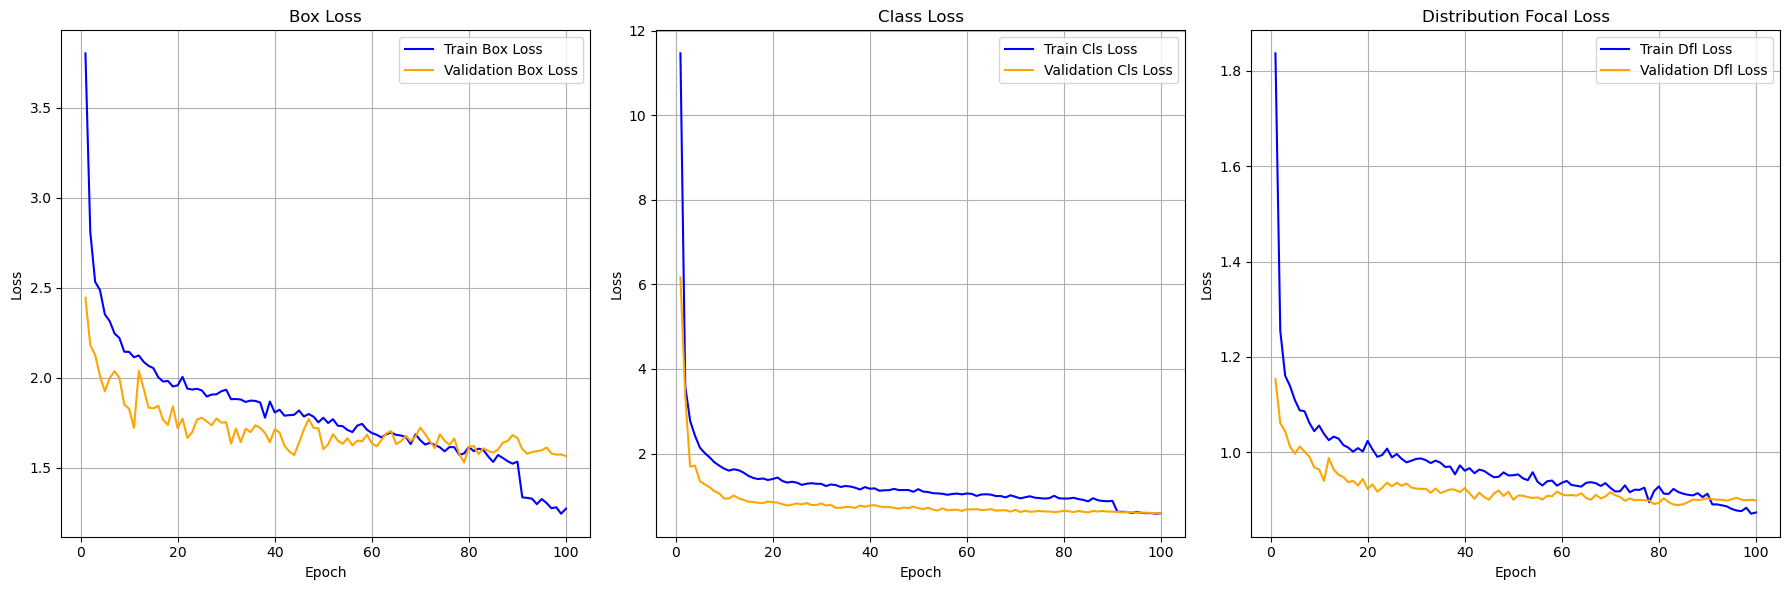

In [46]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot cls loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot dfl loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Predict on test data

In [49]:
best_model_path = os.path.join('pcb/train17/weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join('Dataset1/output/images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/34 /Users/spartan/Desktop/298/Dataset1/output/images/val/01_open_circuit_11.jpg: 640x640 2 open_circuits, 150.2ms
image 2/34 /Users/spartan/Desktop/298/Dataset1/output/images/val/01_open_circuit_12.jpg: 640x640 1 open_circuit, 129.7ms
image 3/34 /Users/spartan/Desktop/298/Dataset1/output/images/val/01_spurious_copper_06.jpg: 640x640 2 spurious_coppers, 150.3ms
image 4/34 /Users/spartan/Desktop/298/Dataset1/output/images/val/04_mouse_bite_17.jpg: 640x640 3 mouse_bites, 123.4ms
image 5/34 /Users/spartan/Desktop/298/Dataset1/output/images/val/04_open_circuit_05.jpg: 640x640 2 open_circuits, 127.5ms
image 6/34 /Users/spartan/Desktop/298/Dataset1/output/images/val/04_spur_02.jpg: 640x640 3 spurs, 120.5ms
image 7/34 /Users/spartan/Desktop/298/Dataset1/output/images/val/04_spur_03.jpg: 640x640 3 spurs, 123.7ms
image 8/34 /Users/spartan/Desktop/298/Dataset1/output/images/val/04_spurious_copper_11.jpg: 640x640 3 spurious_coppers, 121.6ms
image 9/34 /Users/spartan/Desktop/298/Dataset1/o

In [72]:
model.export()

Ultralytics 8.3.27 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M1)

PyTorch: starting from 'pcb/train17/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (21.5 MB)

TorchScript: starting export with torch 2.4.1...
TorchScript: export success ✅ 1.3s, saved as 'pcb/train17/weights/best.torchscript' (42.9 MB)

Export complete (1.6s)
Results saved to /Users/spartan/Desktop/298/pcb/train17/weights
Predict:         yolo predict task=detect model=pcb/train17/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=pcb/train17/weights/best.torchscript imgsz=640 data=Dataset1/data.yaml  
Visualize:       https://netron.app


'pcb/train17/weights/best.torchscript'

In [74]:
best_model_path = os.path.join('pcb/train17/weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join('/Users/spartan/Desktop/12_short_10.jpg')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/1 /Users/spartan/Desktop/12_short_10.jpg: 640x640 5 shorts, 160.7ms
Speed: 1.9ms preprocess, 160.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2
1 label saved to runs/detect/predict2/labels


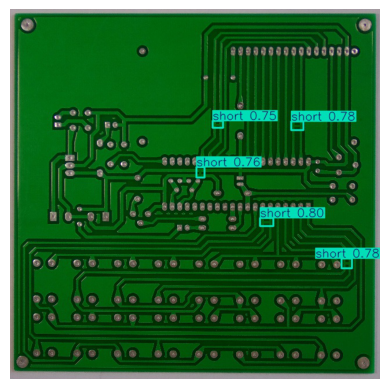

In [75]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the directory
folder_path = '/Users/spartan/Desktop/298/runs/detect/predict2'

# List all files in the directory
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Display each image
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()
